In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [18]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])

In [19]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['EMA_4h'] = df['Price'].ewm(span=48, adjust=False).mean()


df['EMA_1d'] = df['Price'].ewm(span=288, adjust=False).mean()
df['Forecast_difference_0.5 hour future'] = df['Forecast_Roof_0.5 hour future'] - df['Forecast_Demand_0.5 hour future']
df["Forecast_ratio_0.5 hour future"] = df['Forecast_Roof_0.5 hour future'] / df['Forecast_Demand_0.5 hour future']
df.set_index('date', inplace=True)

In [20]:

df = df.drop(columns=['Region', 'Actual_Roof_OPOWER', 'Actual_Roof_LASTCHANGED'])


In [21]:
import re

def drop_future_forecasts(df, threshold_hours, forecast_types=['Demand', 'Roof']):
    """
    Drop future forecast columns from the DataFrame that exceed a specified number of hours.

    Parameters:
    df (pandas.DataFrame): DataFrame containing forecast columns
    threshold_hours (float): Maximum number of future hours to keep
    forecast_types (list): List of forecast types to process

    Returns:
    pandas.DataFrame: DataFrame with specified columns dropped
    """
    columns_to_drop = []
    
    for col in df.columns:
        for forecast_type in forecast_types:
            if col.startswith(f'Forecast_{forecast_type}_'):
                match = re.search(r'(\d+(\.\d+)?) hours? future', col)
                if match:
                    hours = float(match.group(1))
                    if hours > threshold_hours:
                        columns_to_drop.append(col)
    
    return df.drop(columns=columns_to_drop)

# Usage examples
# X_train_filtered = drop_future_forecasts(X_train, 5.0)
# X_test_filtered = drop_future_forecasts(X_test, 5.0)

In [22]:
# df = drop_future_forecasts(df,5.0)

In [23]:
for feature in df.columns:
    
    df[f'{feature}_shift_1'] = df[feature].shift(1)
    df[f'{feature}_shift_6'] = df[feature].shift(6)
df = df.dropna()

C:\Users\Owner\AppData\Local\Temp\ipykernel_15580\1537105346.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_1'] = df[feature].shift(1)
C:\Users\Owner\AppData\Local\Temp\ipykernel_15580\1537105346.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_6'] = df[feature].shift(6)
C:\Users\Owner\AppData\Local\Temp\ipykernel_15580\1537105346.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

In [24]:
df.columns

Index(['Demand', 'Price', 'Forecast_Demand_0.5 hour future',
       'Forecast_Demand_1 hour future', 'Forecast_Demand_1.5 hours future',
       'Forecast_Demand_2 hours future', 'Forecast_Demand_2.5 hours future',
       'Forecast_Demand_3 hours future', 'Forecast_Demand_3.5 hours future',
       'Forecast_Demand_4 hours future',
       ...
       'minute_shift_1', 'minute_shift_6', 'EMA_4h_shift_1', 'EMA_4h_shift_6',
       'EMA_1d_shift_1', 'EMA_1d_shift_6',
       'Forecast_difference_0.5 hour future_shift_1',
       'Forecast_difference_0.5 hour future_shift_6',
       'Forecast_ratio_0.5 hour future_shift_1',
       'Forecast_ratio_0.5 hour future_shift_6'],
      dtype='object', length=153)

In [25]:
X = df.drop('Price', axis=1)
y = df['Price']

train_end_date = pd.to_datetime("2024-04-30 23:59:59")
val_end_date = pd.to_datetime("2024-05-31 23:59:59")
test_start_date = pd.to_datetime("2024-06-01 00:00:00")


X_train = X[X.index <= train_end_date]
X_val = X[(X.index > train_end_date) & (X.index <= val_end_date)]
X_test = X[X.index >= test_start_date]

y_train = y[y.index <= train_end_date]
y_val = y[(y.index > train_end_date) & (y.index <= val_end_date)]
y_test = y[y.index >= test_start_date]

In [26]:
# columns_for_mean = ['Forecast_Roof_0.5 hour future', 'Forecast_Demand_0.5 hour future']
# train_means = X_train[columns_for_mean].mean()
# def create_new_features(df, means):
#     new_features = {}
#     for col in means.index:
#         new_features[f'{col}_diff_from_mean'] = np.abs(df[col] - means[col])
#     return pd.DataFrame(new_features)

# X_train_new = create_new_features(X_train, train_means)

# # 將新特徵添加到原始特徵中
# X_train = pd.concat([X_train, X_train_new], axis=1)

# # 步驟 3: 對 X_test 應用相同的轉換
# X_test_new = create_new_features(X_test, train_means)  # 注意這裡使用的是 train_means
# X_test = pd.concat([X_test, X_test_new], axis=1)

In [27]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 300,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    "lambda":0.9,
    'random_state': 42
}


In [28]:
import xgboost as xgb
model = xgb.XGBRegressor(**params)

# 5. 訓練模型
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)],
          eval_metric='mae',
          early_stopping_rounds=30,
          verbose=True)

c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:65.47999	validation_1-mae:65.77570
[1]	validation_0-mae:64.89229	validation_1-mae:65.17920
[2]	validation_0-mae:64.30017	validation_1-mae:64.59131
[3]	validation_0-mae:63.77150	validation_1-mae:64.13540
[4]	validation_0-mae:63.19755	validation_1-mae:63.55638
[5]	validation_0-mae:62.66359	validation_1-mae:63.05622
[6]	validation_0-mae:62.10461	validation_1-mae:62.49017
[7]	validation_0-mae:61.54478	validation_1-mae:61.92678
[8]	validation_0-mae:60.99754	validation_1-mae:61.37876
[9]	validation_0-mae:60.44391	validation_1-mae:60.83118
[10]	validation_0-mae:59.92054	validation_1-mae:60.29515
[11]	validation_0-mae:59.39081	validation_1-mae:59.76547
[12]	validation_0-mae:58.87476	validation_1-mae:59.23869
[13]	validation_0-mae:58.35564	validation_1-mae:58.72252
[14]	validation_0-mae:57.83860	validation_1-mae:58.20539
[15]	validation_0-mae:57.32945	validation_1-mae:57.69748
[16]	validation_0-mae:56.82703	validation_1-mae:57.18761
[17]	validation_0-mae:56.36530	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.9, learning_rate=0.01,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, ...)

In [29]:
y_pred = model.predict(X_test)

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 29559.30600178694
Mean Absolute Error: 26.164265741784703
Root Mean Squared Error: 171.92820013536738


In [31]:
feature_importance = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))


Top 10 Most Important Features:
                                         feature  importance
49                Forecast_ratio_0.5 hour future    0.067038
148  Forecast_difference_0.5 hour future_shift_1    0.062700
144                               EMA_4h_shift_1    0.057110
52                                 Price_shift_1    0.053247
150       Forecast_ratio_0.5 hour future_shift_1    0.047146
20                 Forecast_Roof_0.5 hour future    0.041890
92         Forecast_Roof_0.5 hour future_shift_1    0.041132
64        Forecast_Demand_3 hours future_shift_1    0.033846
146                               EMA_1d_shift_1    0.032327
40                   Adjusted_Actual_Roof_OPOWER    0.031011


In [32]:
feature_importance_df.head(30)

feature  importance
49                Forecast_ratio_0.5 hour future    0.067038
148  Forecast_difference_0.5 hour future_shift_1    0.062700
144                               EMA_4h_shift_1    0.057110
52                                 Price_shift_1    0.053247
150       Forecast_ratio_0.5 hour future_shift_1    0.047146
20                 Forecast_Roof_0.5 hour future    0.041890
92         Forecast_Roof_0.5 hour future_shift_1    0.041132
64        Forecast_Demand_3 hours future_shift_1    0.033846
146                               EMA_1d_shift_1    0.032327
40                   Adjusted_Actual_Roof_OPOWER    0.031011
46                                        EMA_4h    0.028821
94           Forecast_Roof_1 hour future_shift_1    0.021323
151       Forecast_ratio_0.5 hour future_shift_6    0.020811
48           Forecast_difference_0.5 hour future    0.020121
47                                        EMA_1d    0.016863
74      Forecast_Demand_5.5 hours future_shift_1    0.015366
78      Forecast_Demand_6.5 hours future_shift_1    0.013211
147                               EMA_1d_shift_6    0.012557
132          Adjusted_Actual_Roof_OPOWER_shift_1    0.012066
133          Adjusted_Actual_Roof_OPOWER_shift_6    0.011675
6                 Forecast_Demand_3 hours future    0.011397
62      Forecast_Demand_2.5 hours future_shift_1    0.011265
79      Forecast_Demand_6.5 hours future_shift_6    0.011161
11              Forecast_Demand_5.5 hours future    0.010338
80        Forecast_Demand_7 hours future_shift_1    0.010245
55       Forecast_Demand_0.5 hour future_shift_6    0.010080
93         Forecast_Roof_0.5 hour future_shift_6    0.009152
66      Forecast_Demand_3.5 hours future_shift_1    0.008585
9               Forecast_Demand_4.5 hours future    0.008148
143                               minute_shift_6    0.007629

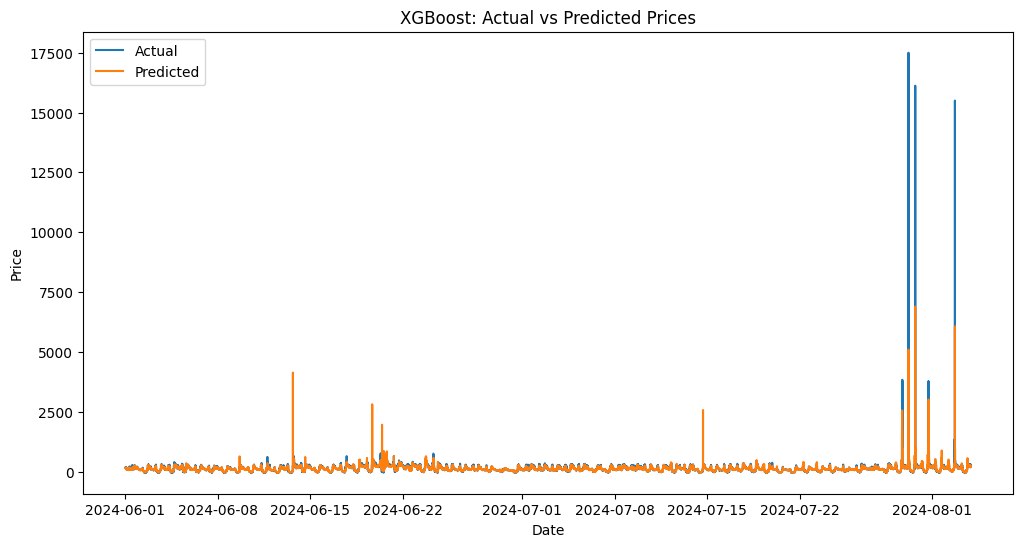

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('XGBoost: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

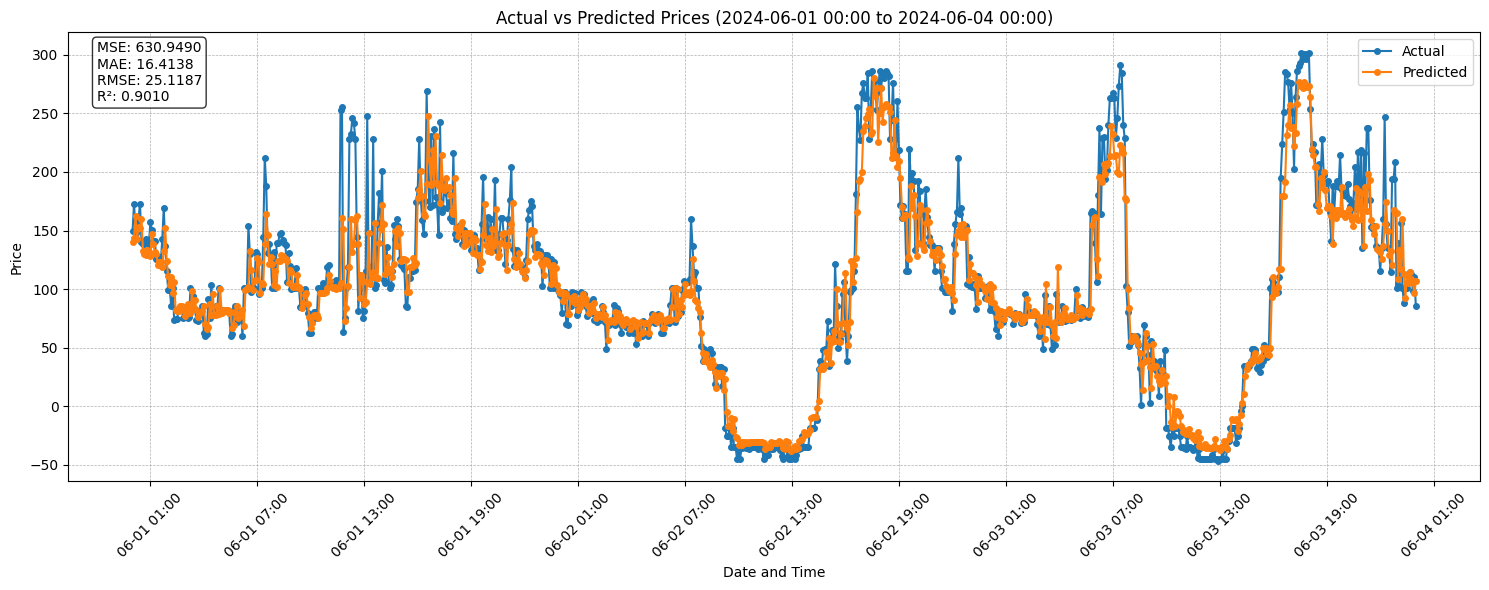

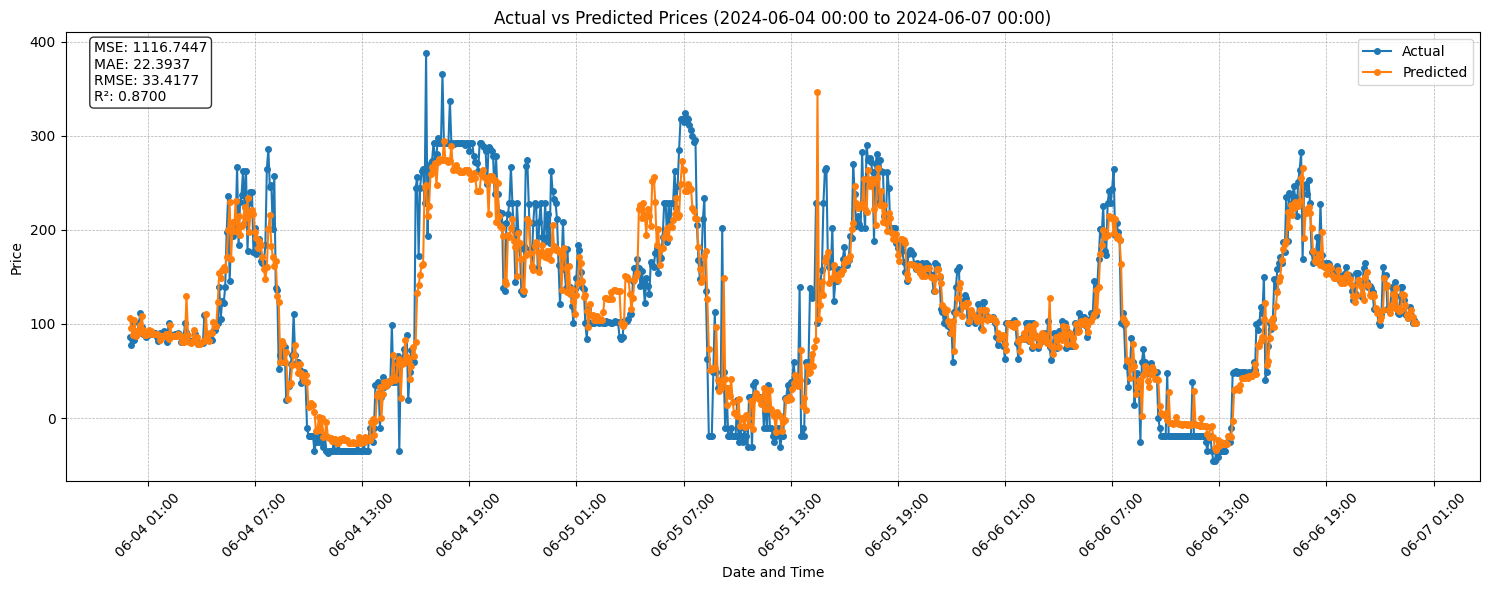

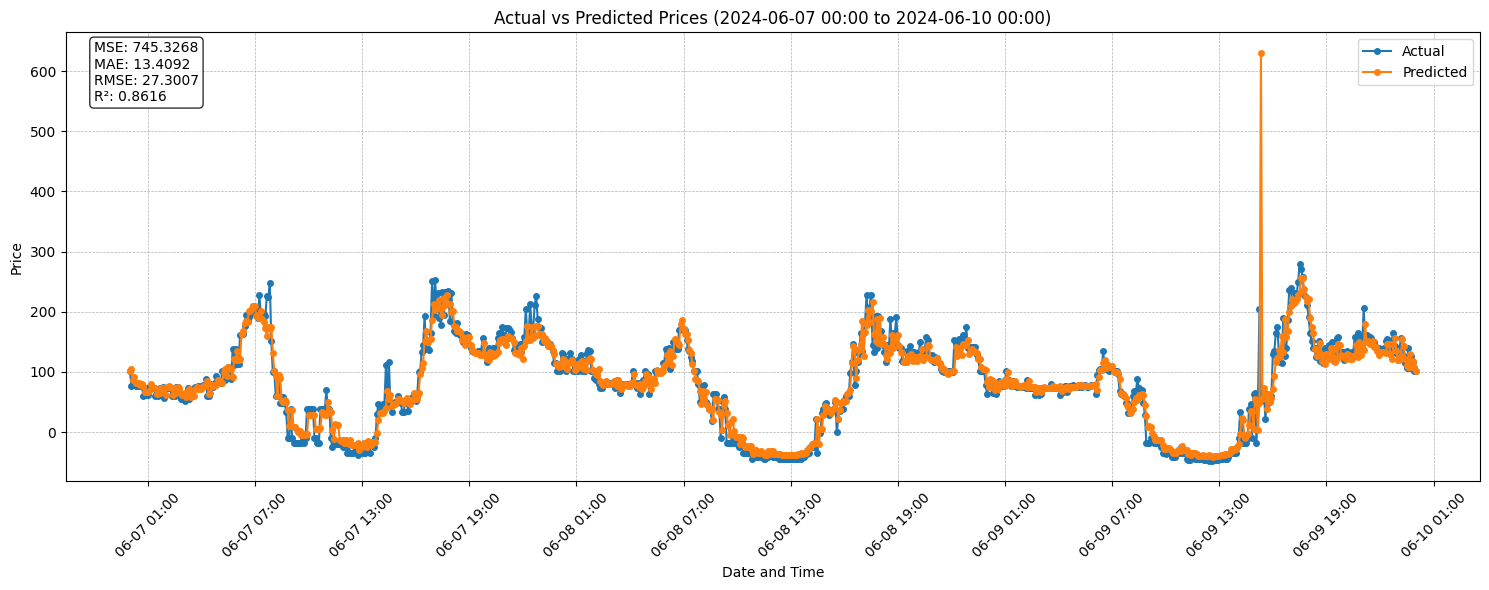

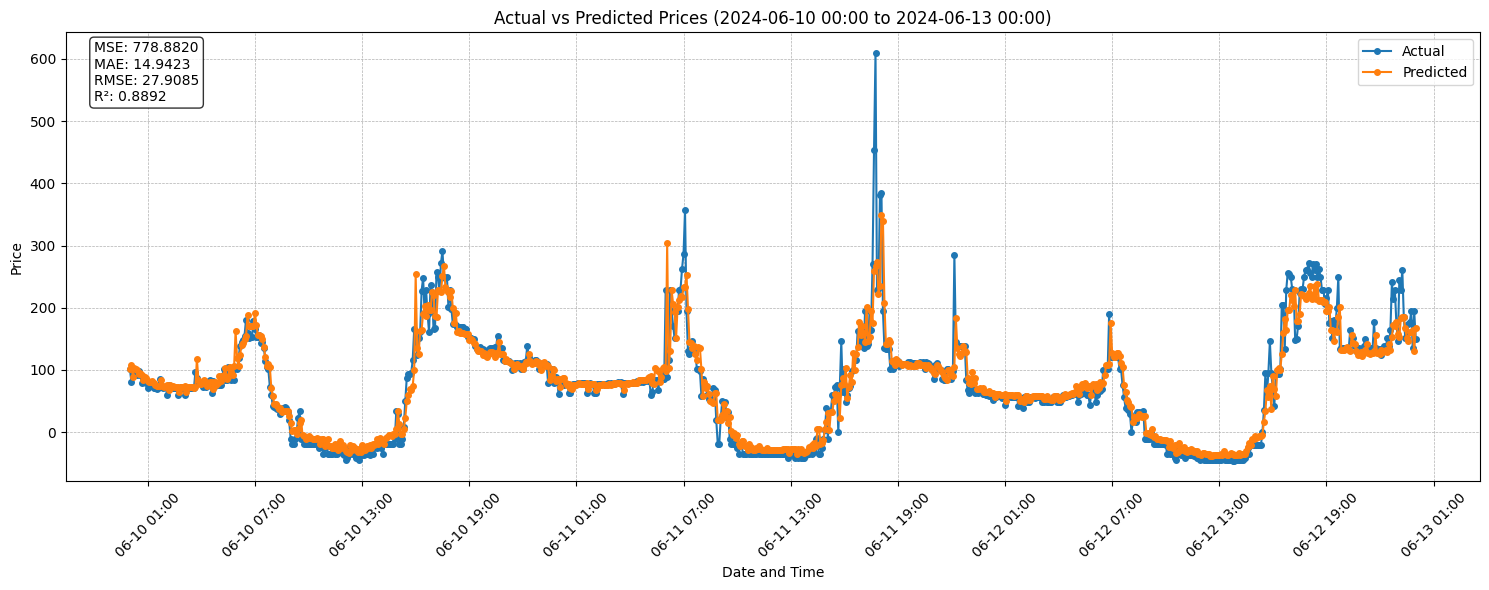

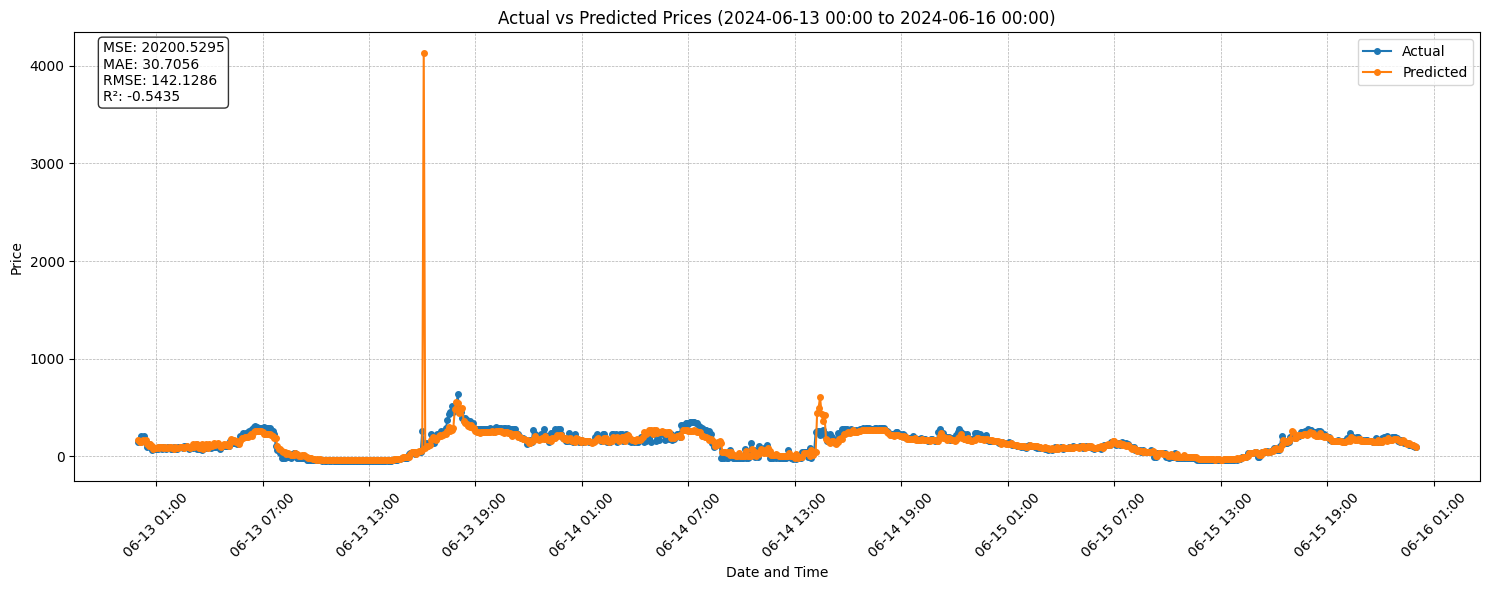

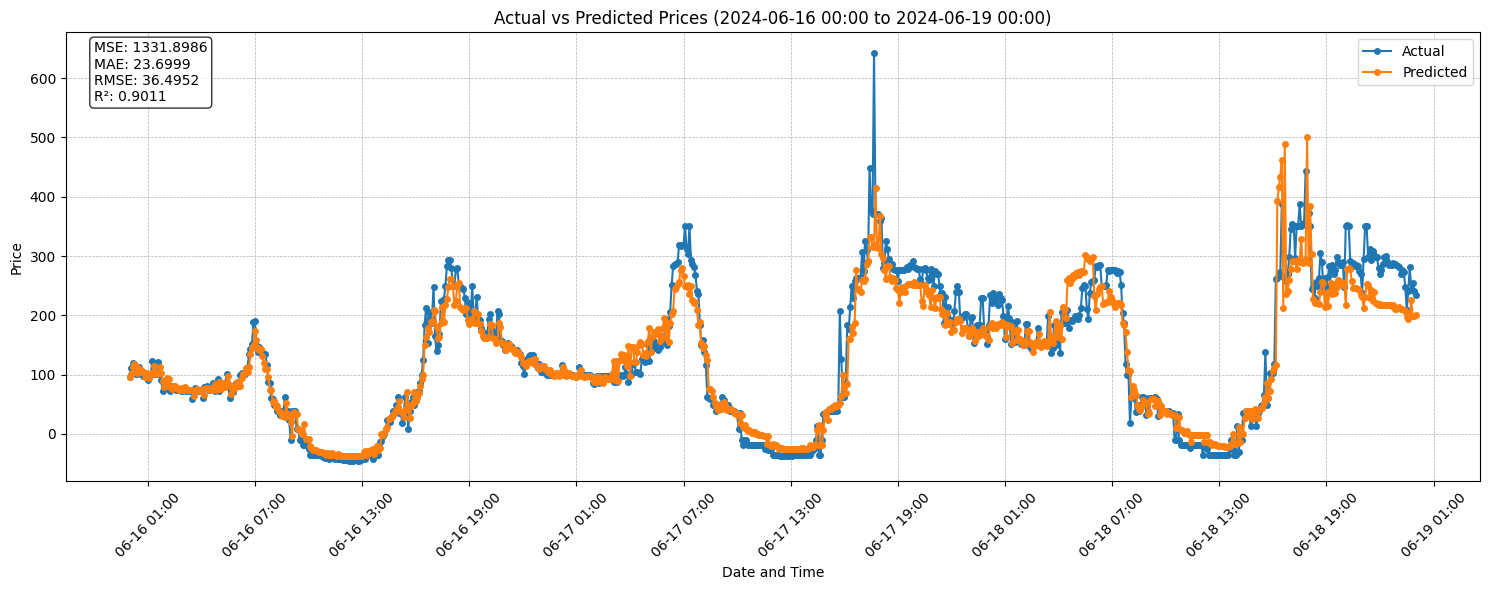

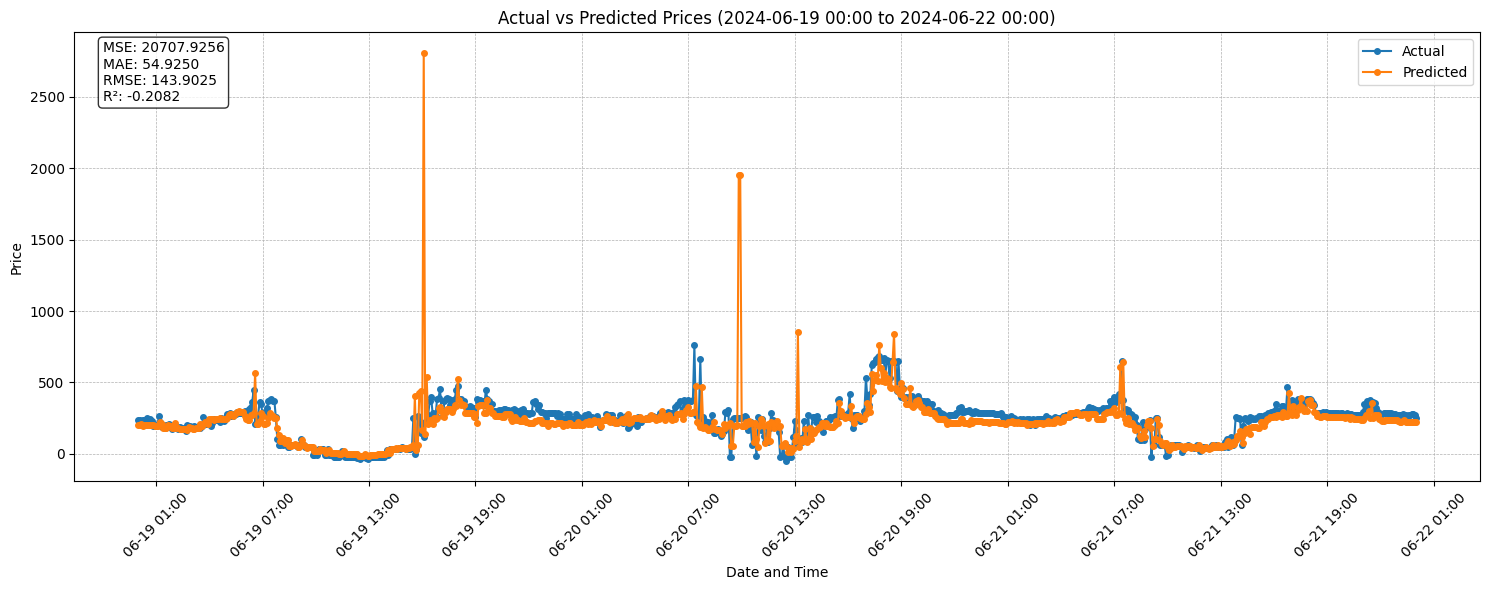

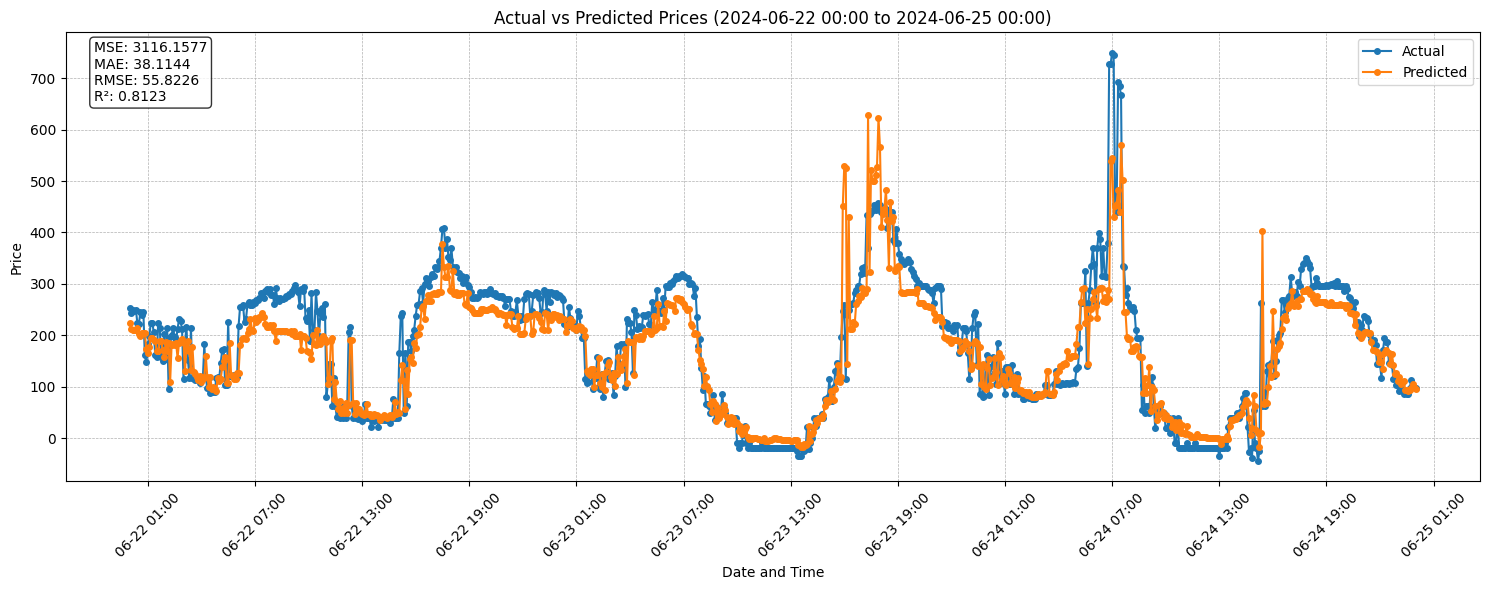

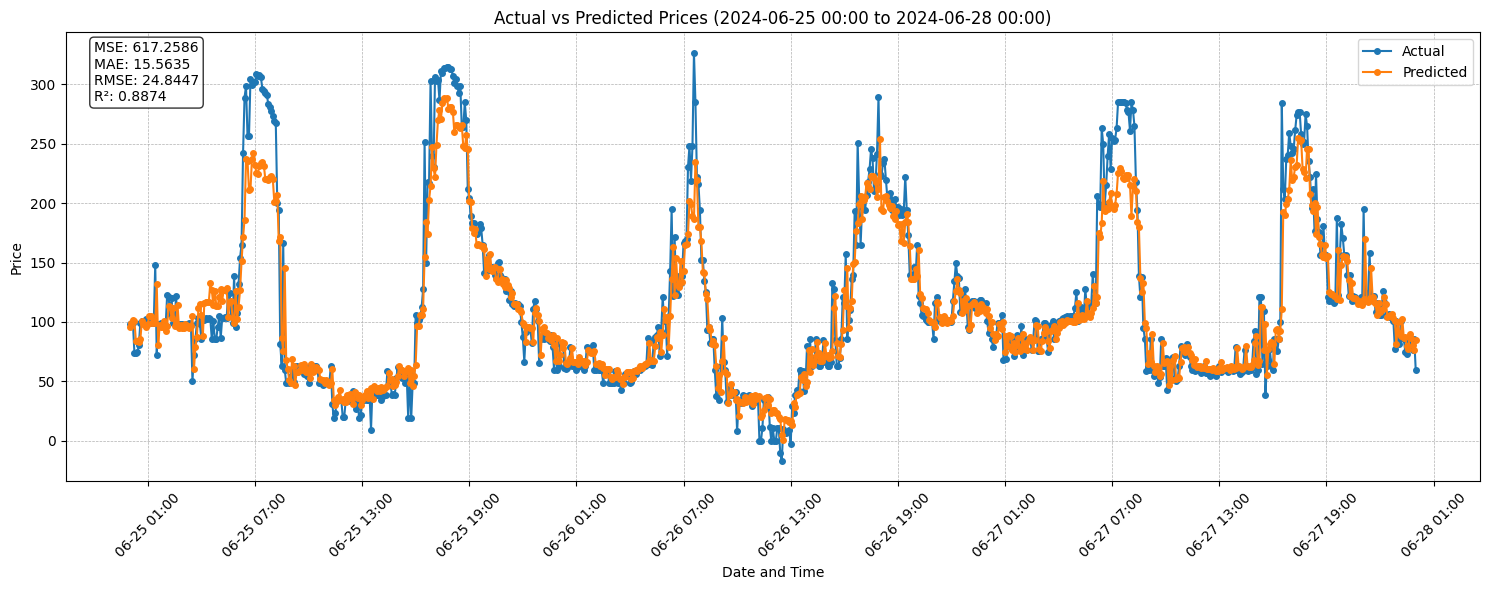

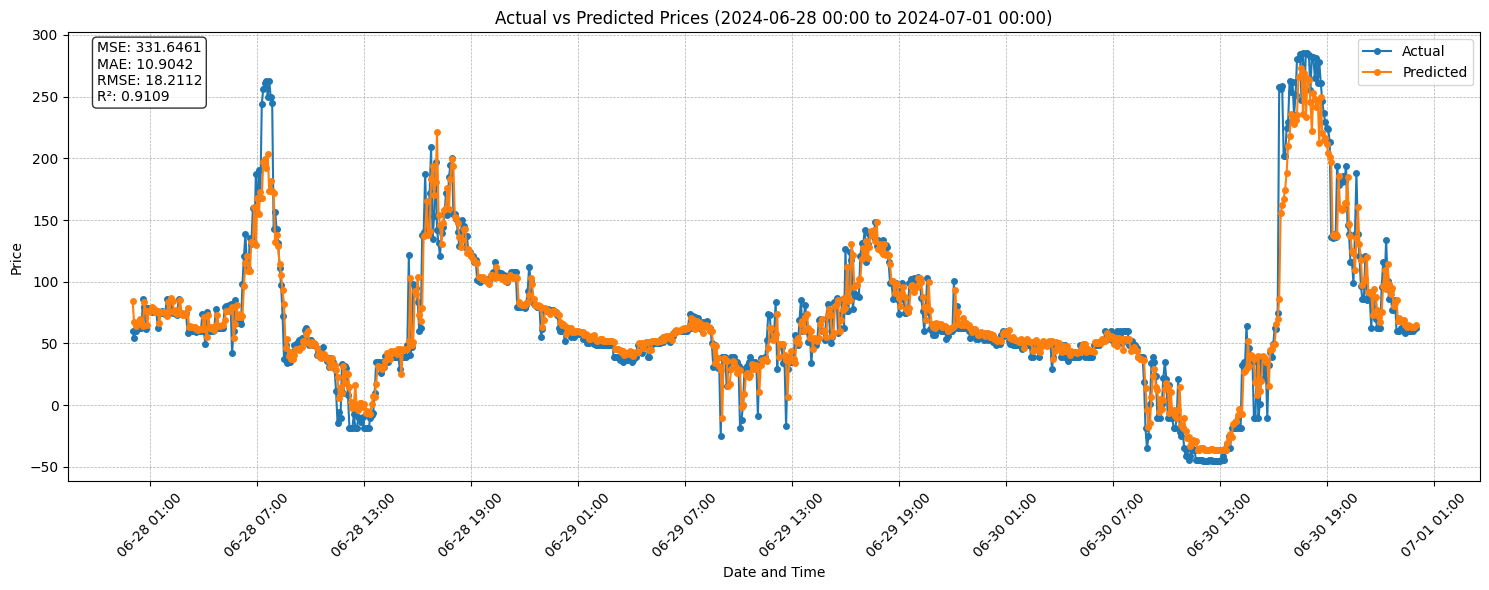

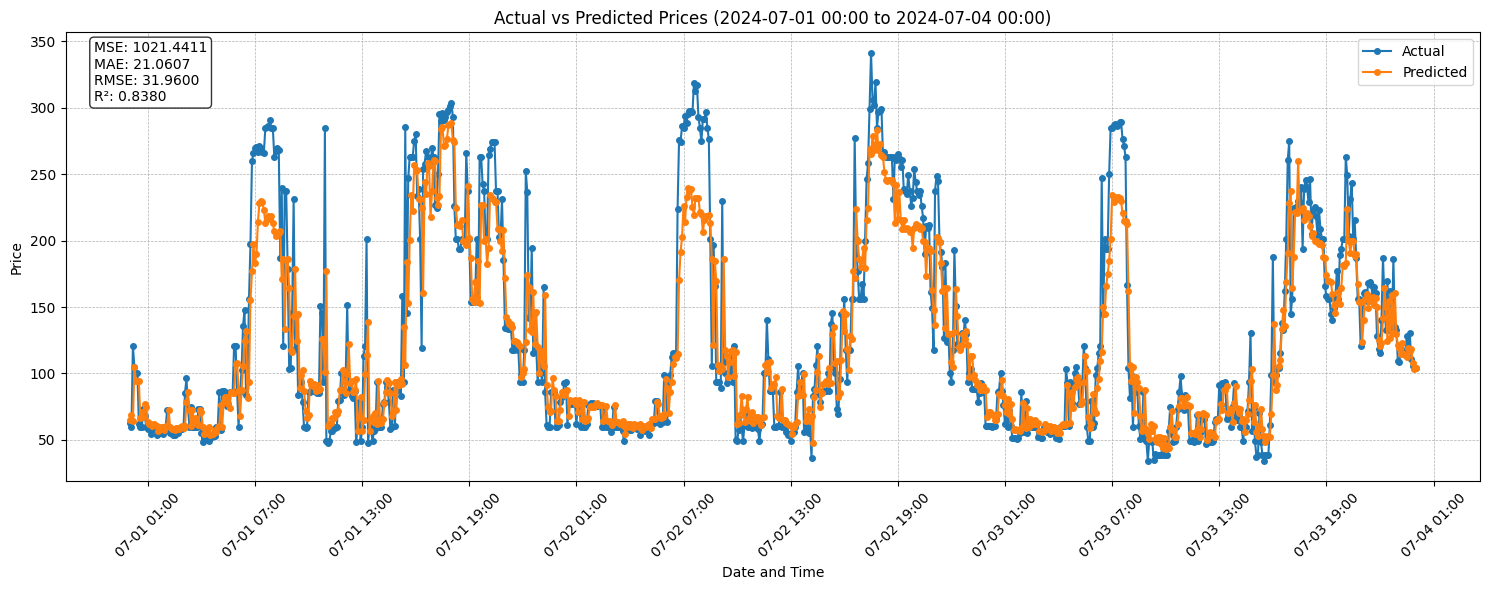

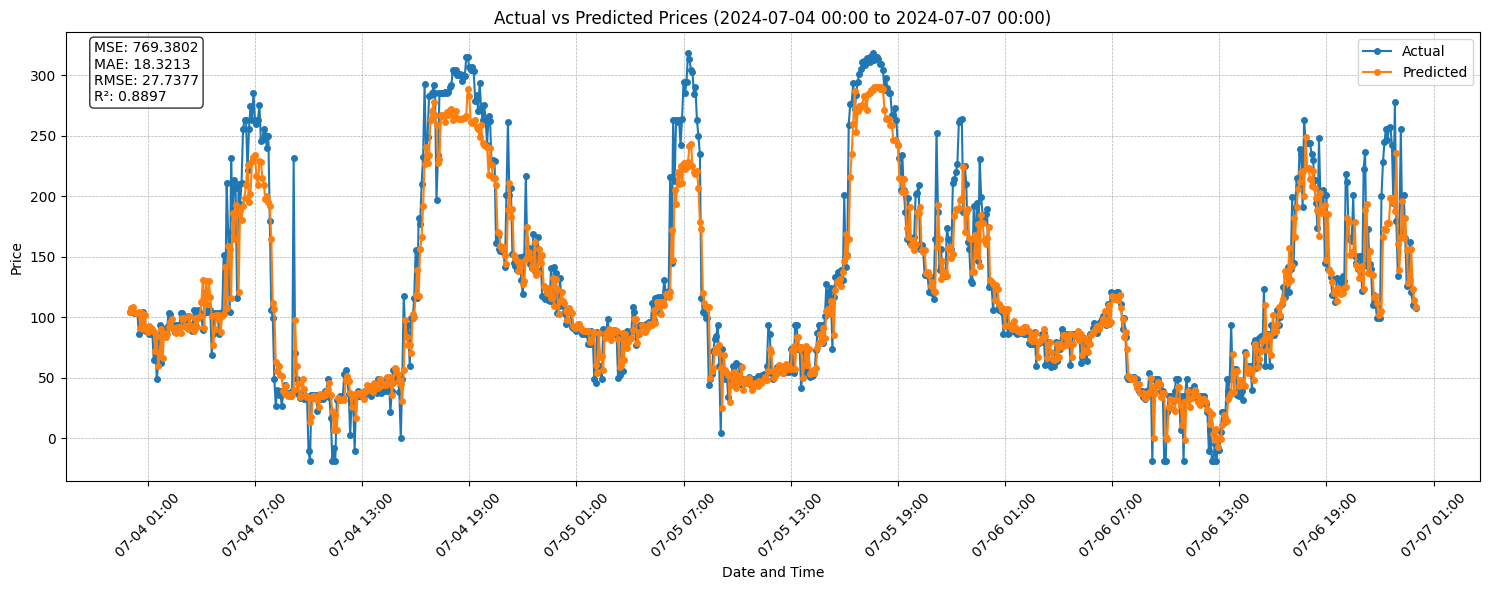

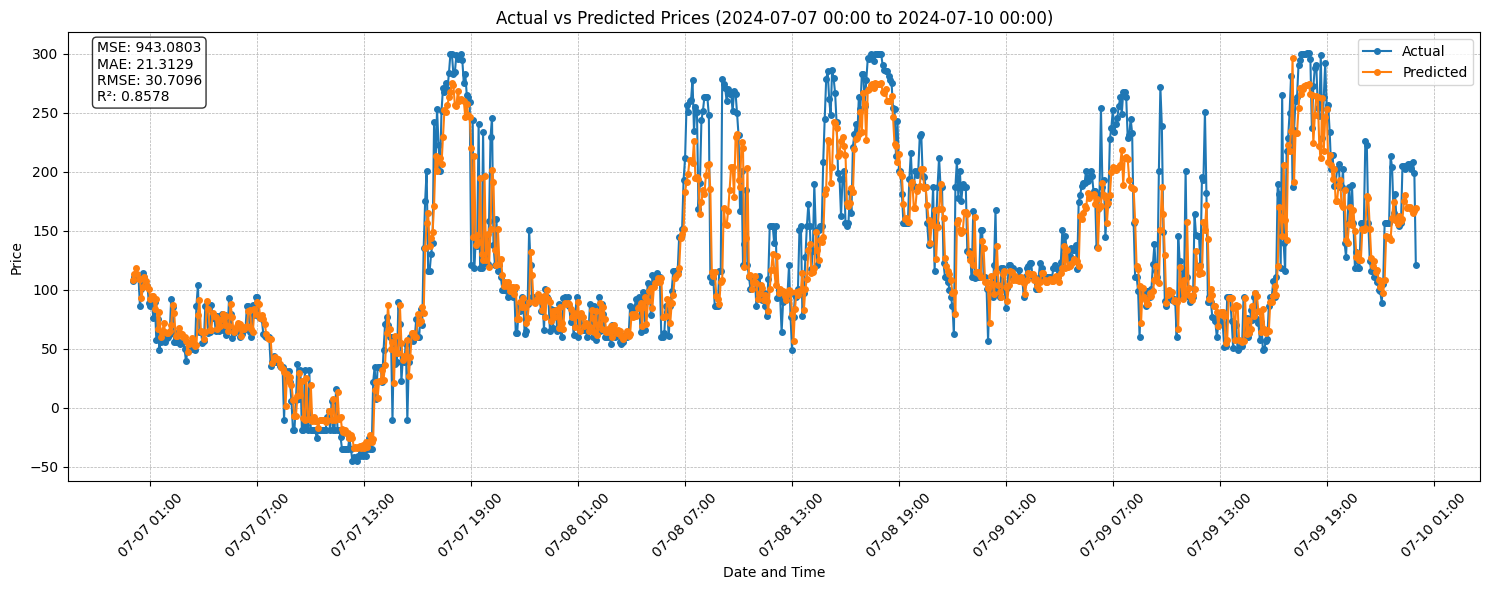

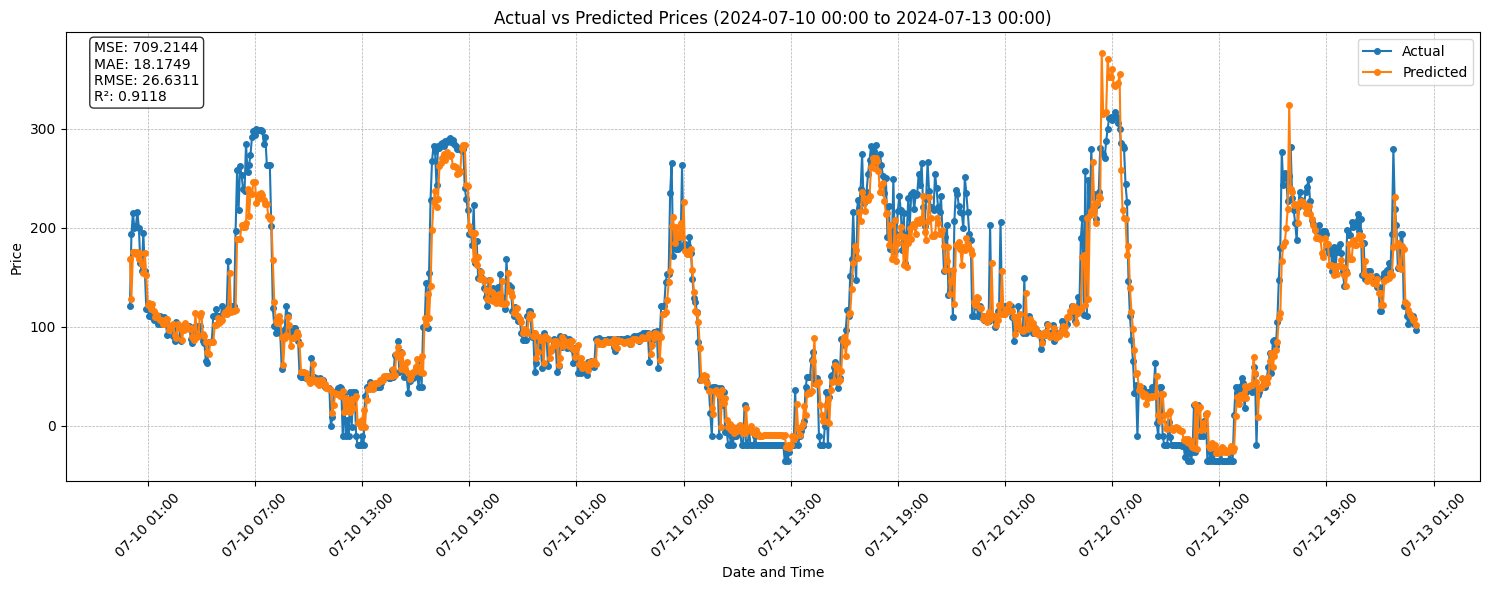

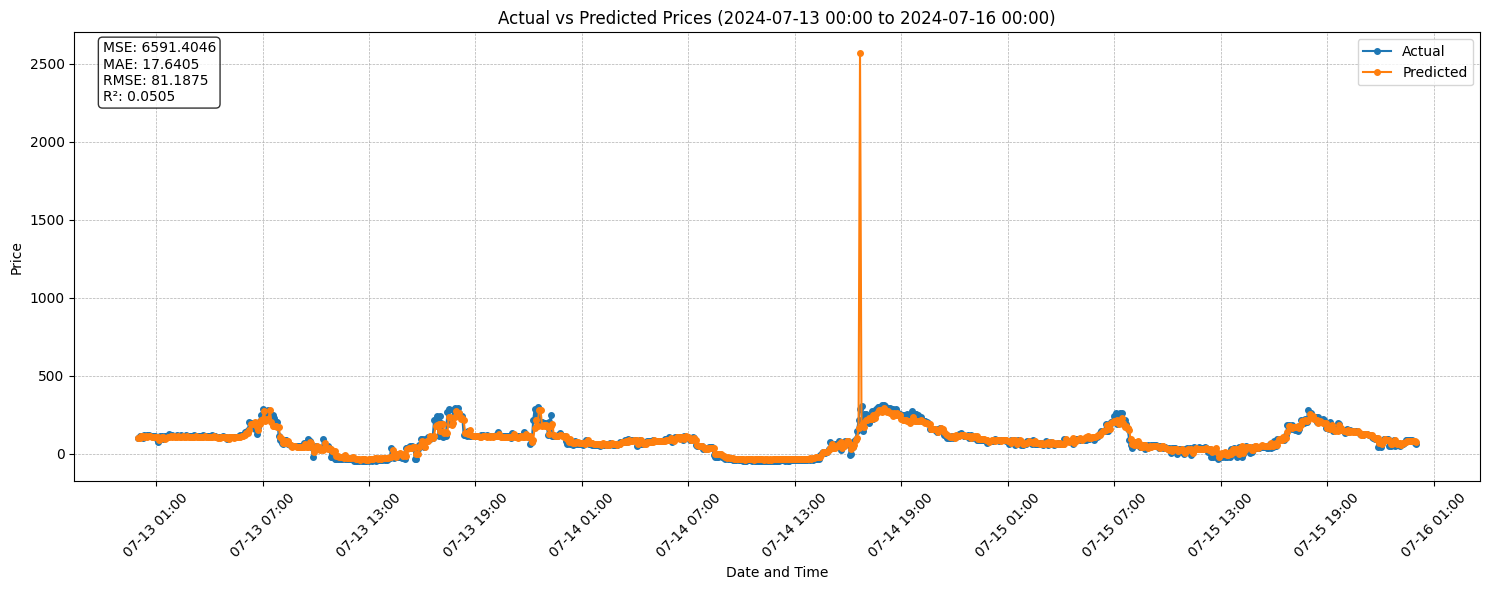

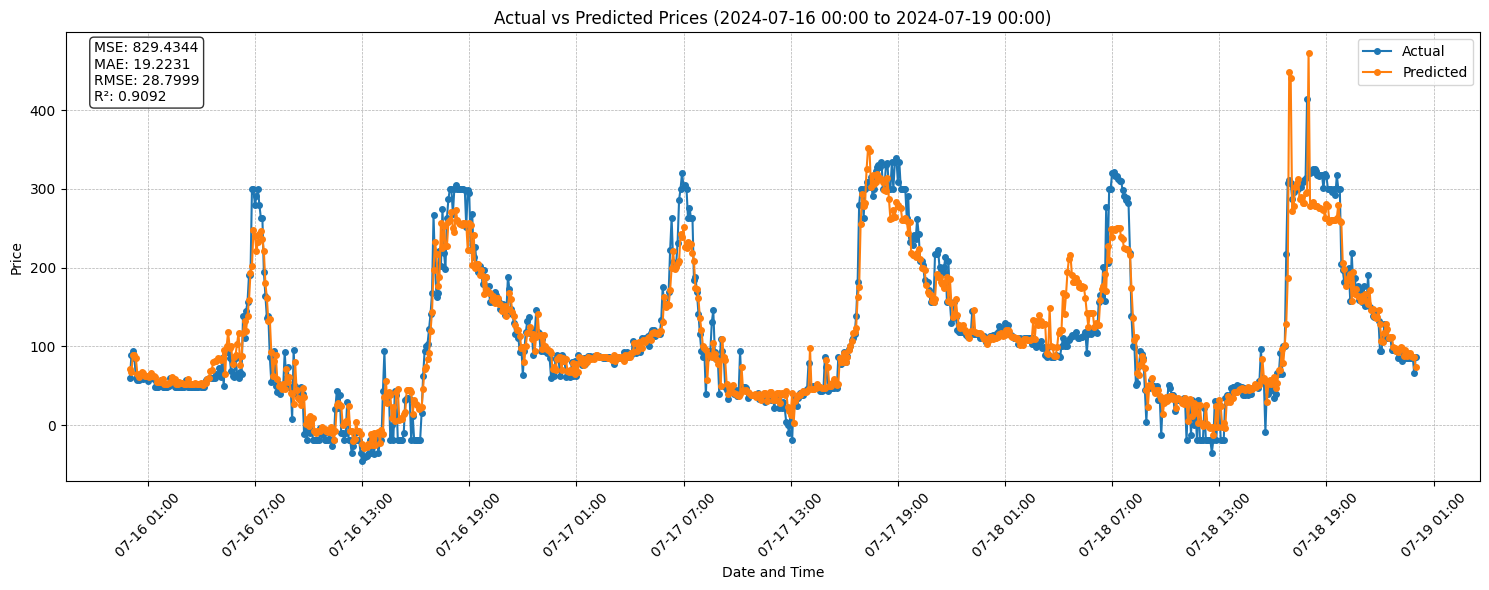

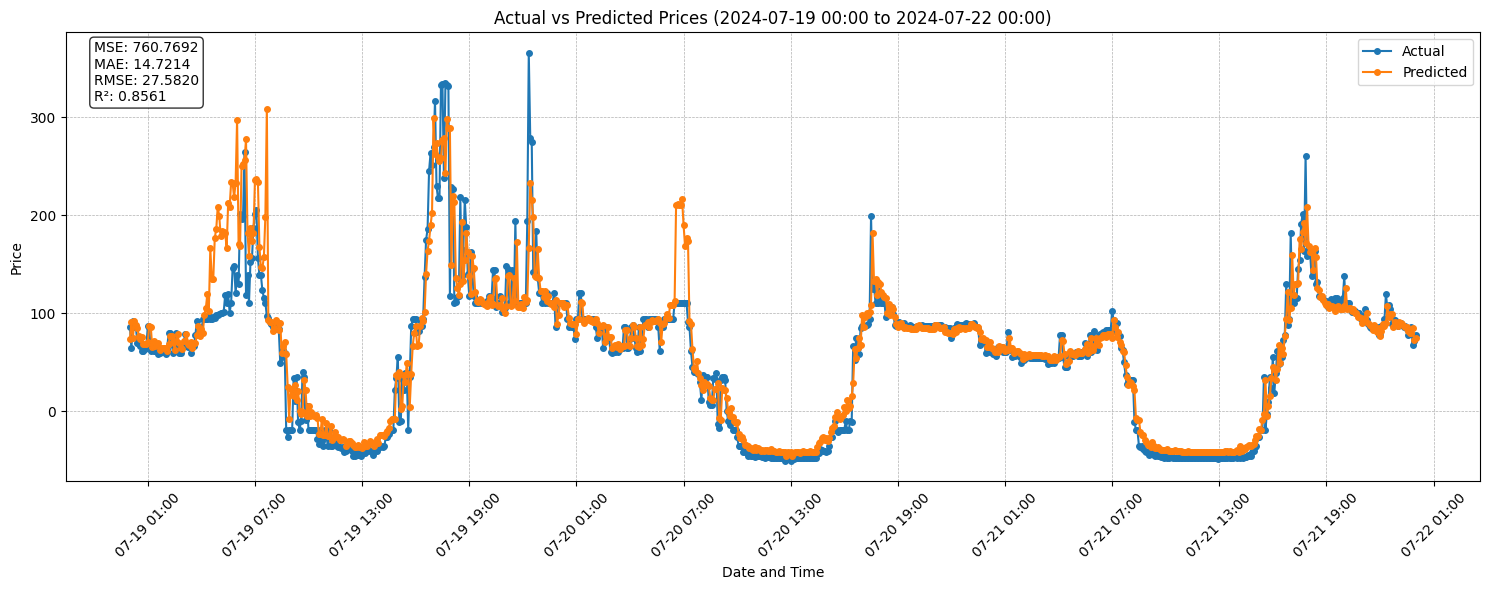

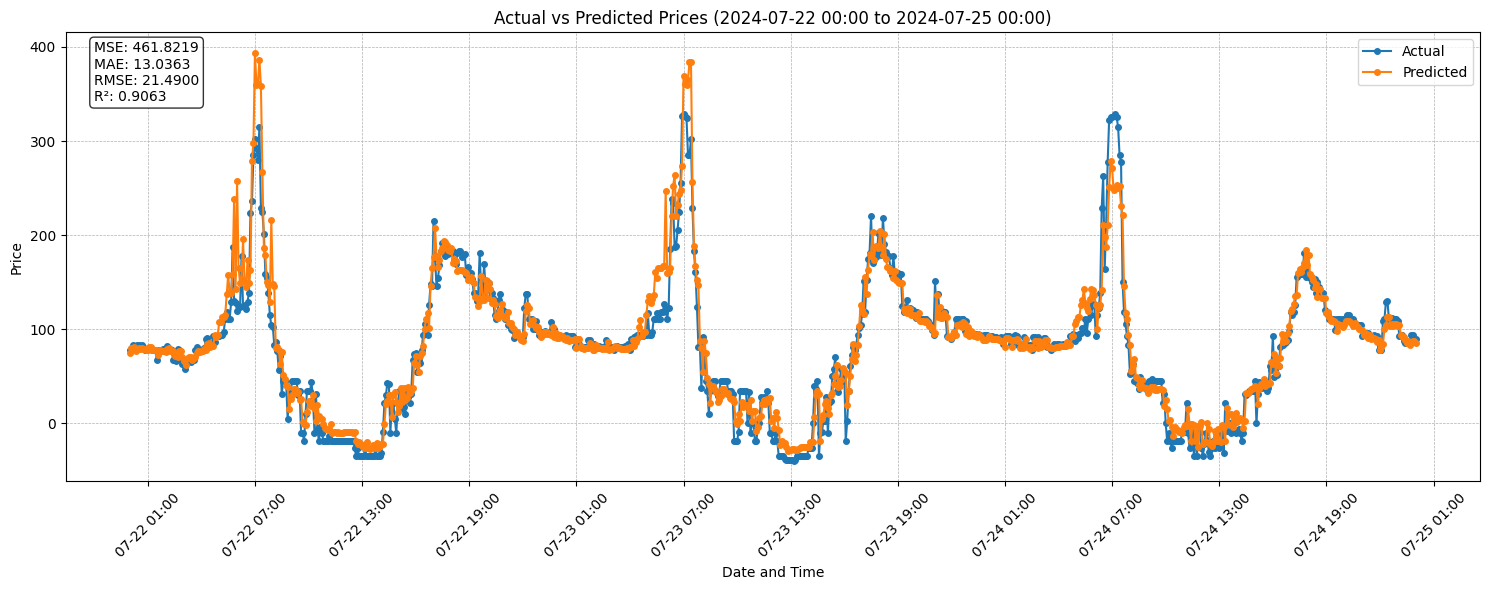

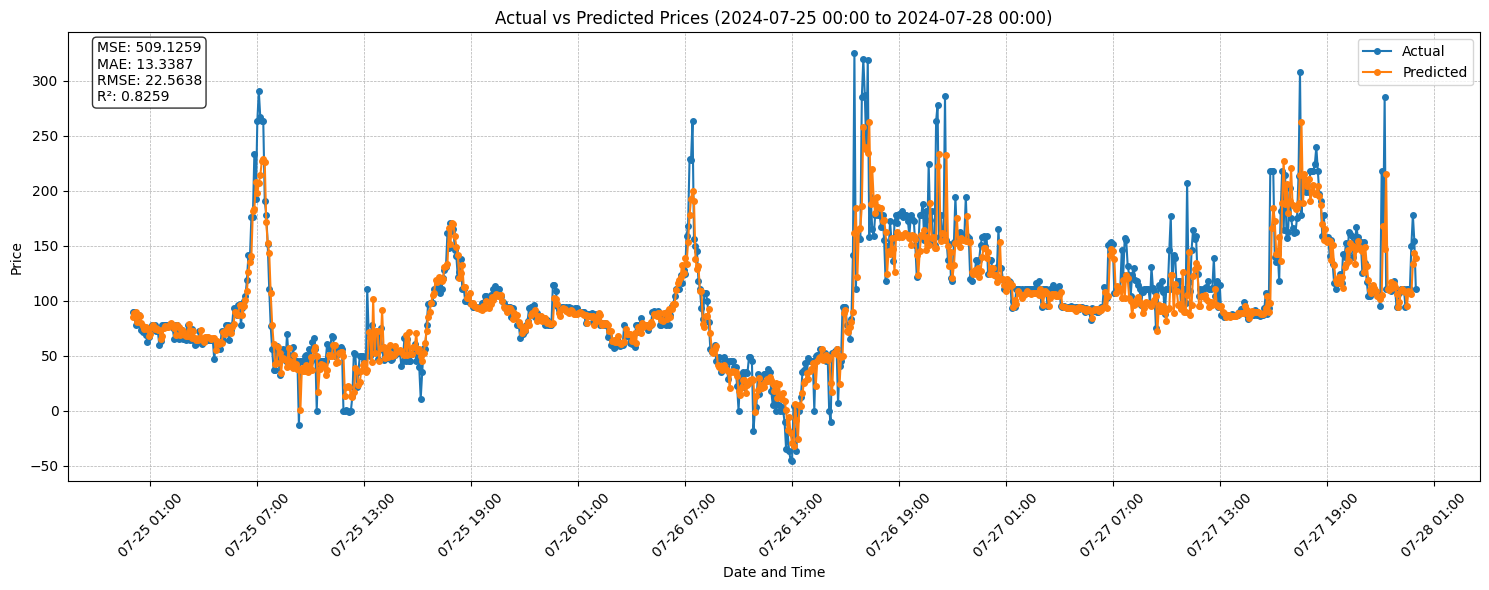

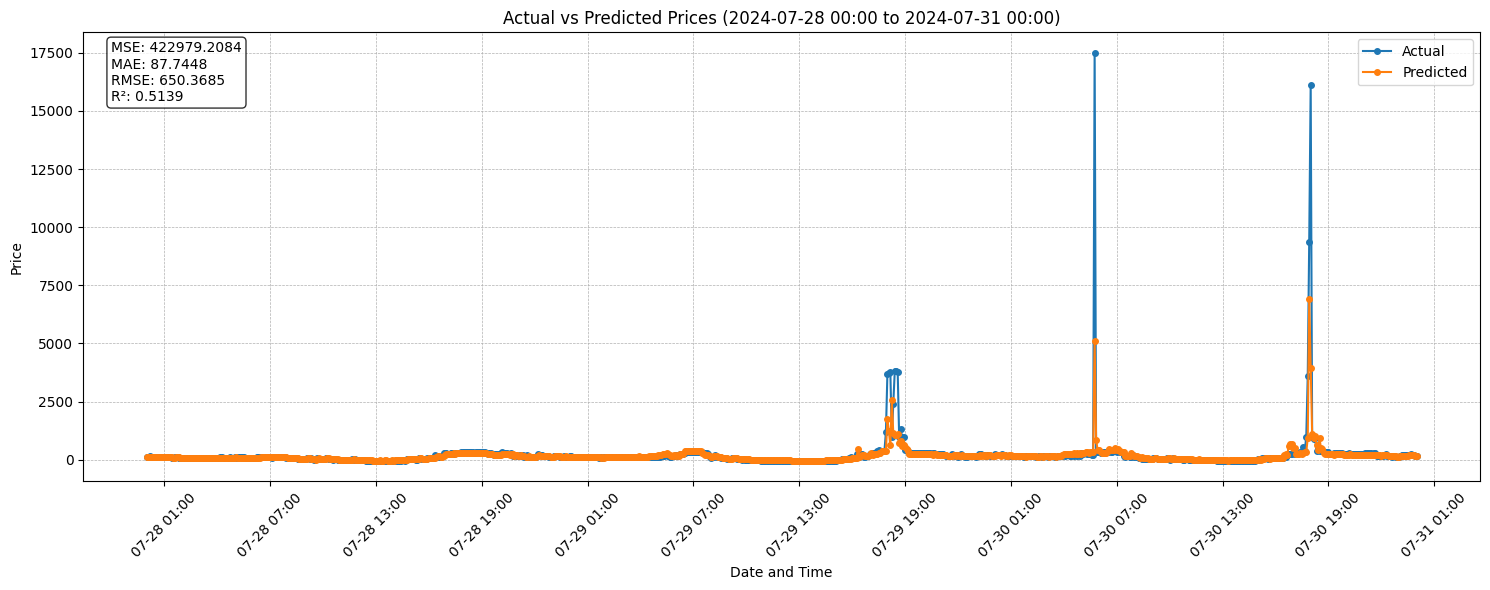

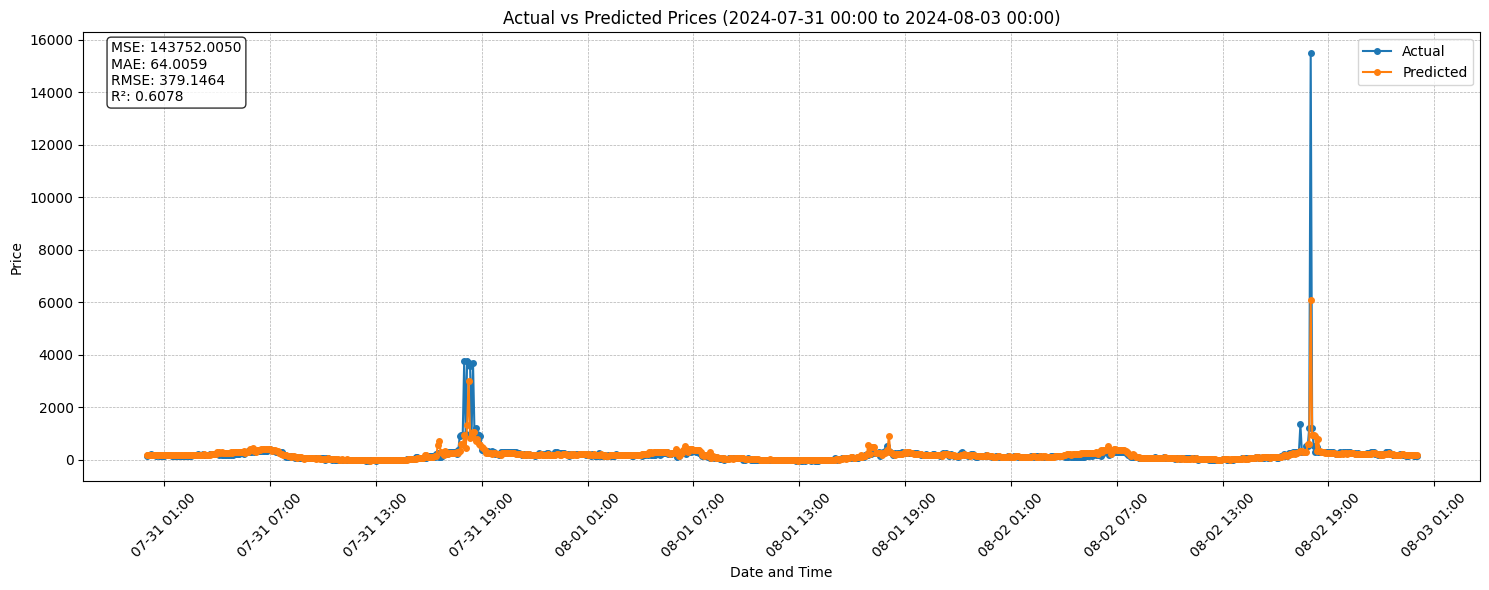

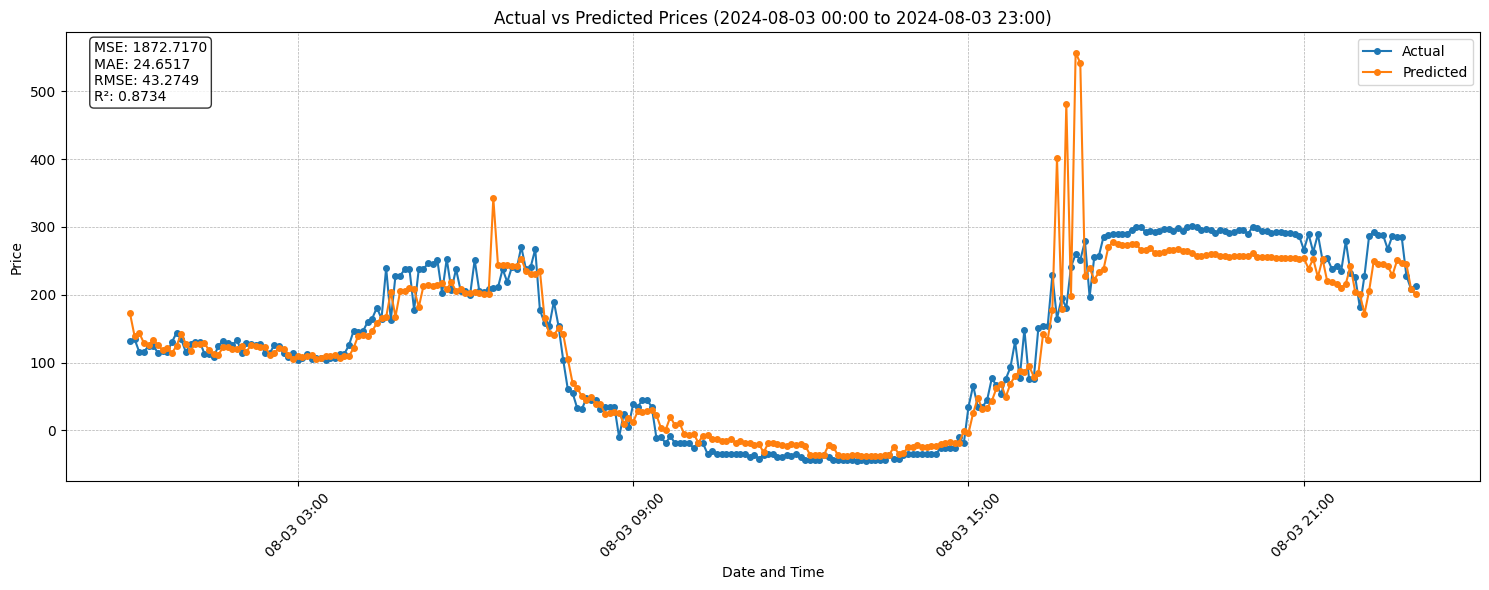

Overall Performance Metrics:
Mean Squared Error: 29559.3060
Mean Absolute Error: 26.1643
Root Mean Squared Error: 171.9282
R-squared Score: 0.5635


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

def plot_three_day_comparison(data, start_date, end_date):
    period_data = data.loc[start_date:end_date]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(period_data.index, period_data['Actual'], label='Actual', marker='o', markersize=4)
    ax.plot(period_data.index, period_data['Predicted'], label='Predicted', marker='o', markersize=4)
    
    ax.set_title(f'Actual vs Predicted Prices ({start_date.strftime("%Y-%m-%d %H:%M")} to {end_date.strftime("%Y-%m-%d %H:%M")})')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Price')
    ax.legend()
    

    ax.xaxis.set_major_locator(HourLocator(interval=6))  
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))  

    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    

    mse = mean_squared_error(period_data['Actual'], period_data['Predicted'])
    mae = mean_absolute_error(period_data['Actual'], period_data['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(period_data['Actual'], period_data['Predicted'])
    
    metrics_text = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR²: {r2:.4f}'
    plt.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()


start_date = results_df.index.min()
end_date = results_df.index.max()


current_date = start_date
while current_date <= end_date:
    period_end = min(current_date + pd.Timedelta(days=3), end_date)
    plot_three_day_comparison(results_df, current_date, period_end)
    current_date += pd.Timedelta(days=3)


# mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
# mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
# rmse = np.sqrt(mse)
# r2 = r2_score(results_df['Actual'], results_df['Predicted'])

# print(f"Overall Performance Metrics:")
# print(f"Mean Squared Error: {mse:.4f}")
# print(f"Mean Absolute Error: {mae:.4f}")
# print(f"Root Mean Squared Error: {rmse:.4f}")
# print(f"R-squared Score: {r2:.4f}")

Hourly Success Rate (sorted from highest to lowest):
hour
2     0.657552
1     0.644531
3     0.643229
20    0.613281
19    0.588542
0     0.584635
21    0.580729
23    0.575958
18    0.553385
4     0.549479
5     0.494792
17    0.486979
22    0.462240
6     0.384115
16    0.325521
8     0.298177
7     0.291667
15    0.244792
14    0.238281
10    0.208333
9     0.187500
13    0.179688
11    0.170573
12    0.130208
Name: is_successful, dtype: float64


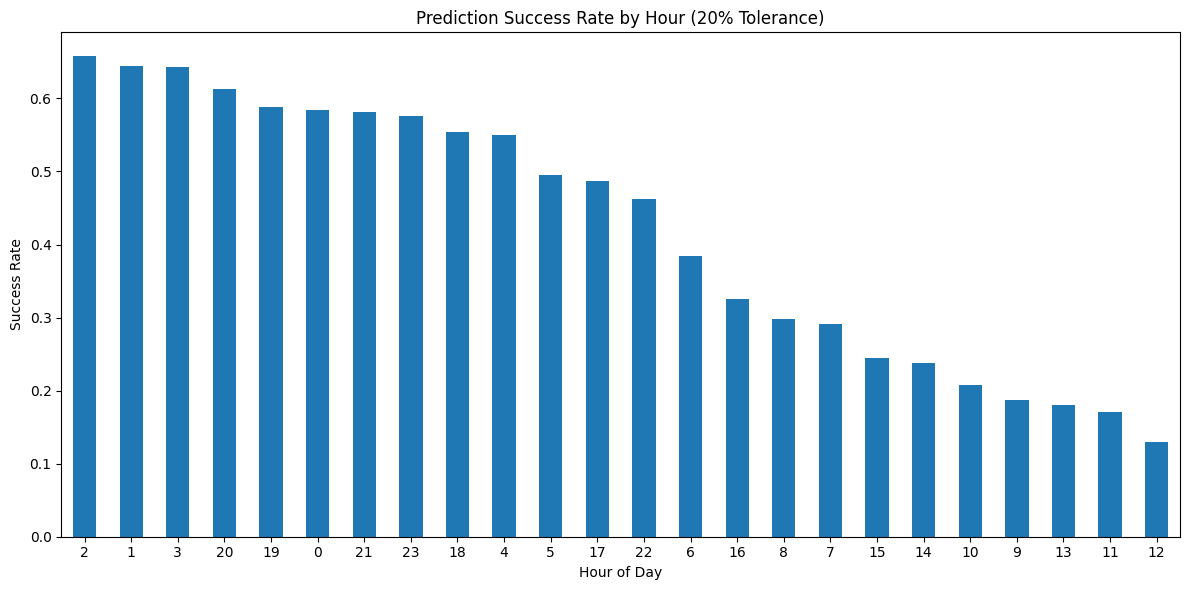

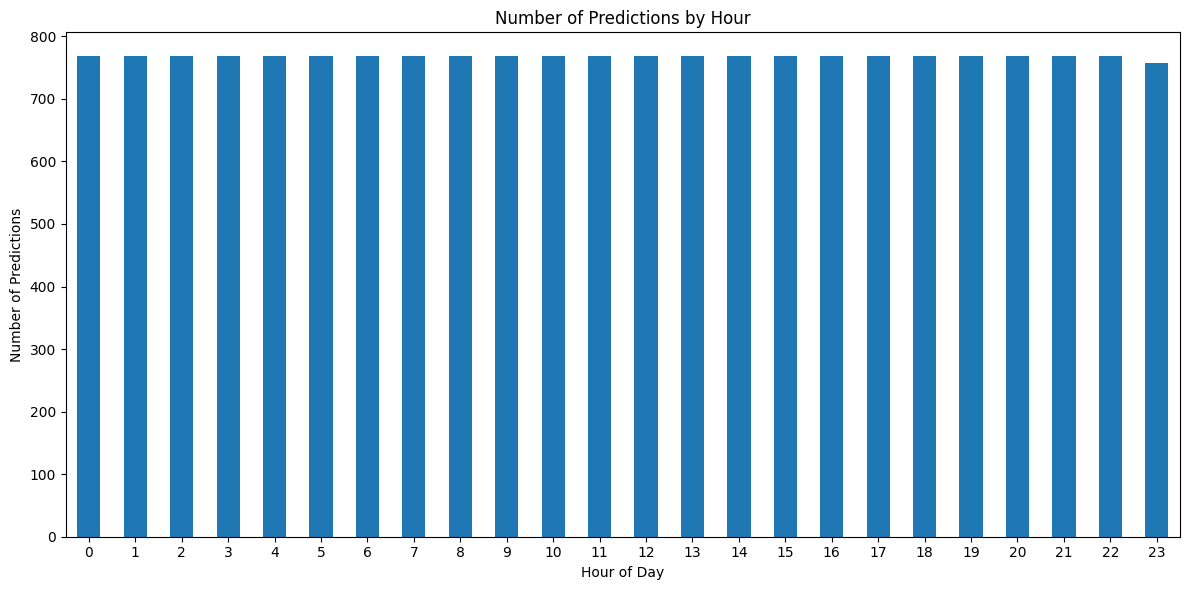


Top 5 hours with highest success rate:
hour
2     0.657552
1     0.644531
3     0.643229
20    0.613281
19    0.588542
Name: is_successful, dtype: float64

Bottom 5 hours with lowest success rate:
hour
12    0.130208
11    0.170573
13    0.179688
9     0.187500
10    0.208333
Name: is_successful, dtype: float64

Overall Success Rate: 42.05%


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



def is_prediction_successful(actual, predicted, tolerance=0.1):
    return abs(predicted - actual) <= abs(actual * tolerance)

results_df['is_successful'] = results_df.apply(lambda row: is_prediction_successful(row['Actual'], row['Predicted']), axis=1)


results_df['hour'] = results_df.index.hour
hourly_success_rate = results_df.groupby('hour')['is_successful'].mean().sort_values(ascending=False)


hourly_prediction_count = results_df.groupby('hour').size()


print("Hourly Success Rate (sorted from highest to lowest):")
print(hourly_success_rate)


plt.figure(figsize=(12, 6))
hourly_success_rate.plot(kind='bar')
plt.title('Prediction Success Rate by Hour (20% Tolerance)')
plt.xlabel('Hour of Day')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
hourly_prediction_count.plot(kind='bar')
plt.title('Number of Predictions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


top_5_hours = hourly_success_rate.nlargest(5)
bottom_5_hours = hourly_success_rate.nsmallest(5)

print("\nTop 5 hours with highest success rate:")
print(top_5_hours)

print("\nBottom 5 hours with lowest success rate:")
print(bottom_5_hours)


overall_success_rate = results_df['is_successful'].mean()
print(f"\nOverall Success Rate: {overall_success_rate:.2%}")


# fig, ax1 = plt.subplots(figsize=(15, 6))

# ax1.bar(hourly_success_rate.index, hourly_success_rate.values, alpha=0.7, color='b', label='Success Rate')
# ax1.set_xlabel('Hour of Day')
# ax1.set_ylabel('Success Rate', color='b')
# ax1.tick_params(axis='y', labelcolor='b')

# ax2 = ax1.twinx()
# ax2.plot(hourly_prediction_count.index, hourly_prediction_count.values, color='r', label='Prediction Count')
# ax2.set_ylabel('Number of Predictions', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# plt.title('Prediction Success Rate and Count by Hour')
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
# plt.tight_layout()
# plt.show()

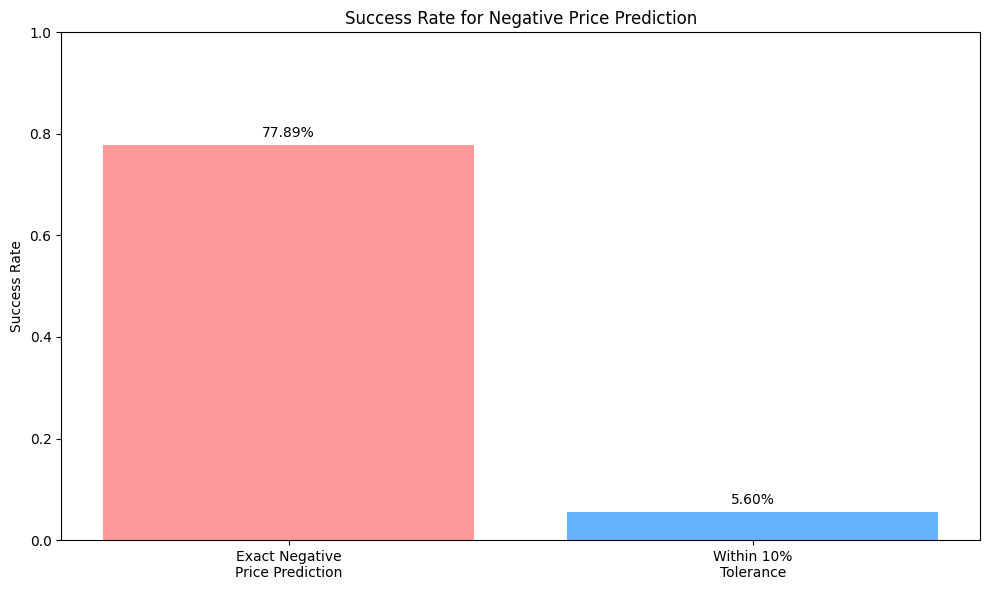

Exact Negative Price Prediction Success Rate: 77.89%
Negative Price Prediction Success Rate (10% Tolerance): 5.60%
Frequency of Negative Prices: 12.79%


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def is_prediction_successful(actual, predicted, tolerance=0.1):
    return abs(predicted - actual) <= abs(actual * tolerance)


results_df['is_successful'] = results_df.apply(lambda row: is_prediction_successful(row['Actual'], row['Predicted']), axis=1)


def analyze_negative_price_prediction(df):
    negative_price_df = df[df['Actual'] < 0]
    

    exact_success = ((negative_price_df['Predicted'] < 0) & (negative_price_df['Actual'] < 0)).mean()

    tolerance_success = negative_price_df['is_successful'].mean()
    
    return exact_success, tolerance_success


exact_success_rate, tolerance_success_rate = analyze_negative_price_prediction(results_df)


plt.figure(figsize=(10, 6))
success_rates = [exact_success_rate, tolerance_success_rate]
labels = ['Exact Negative\nPrice Prediction', 'Within 10%\nTolerance']
colors = ['#FF9999', '#66B2FF']

plt.bar(labels, success_rates, color=colors)
plt.title('Success Rate for Negative Price Prediction')
plt.ylabel('Success Rate')
plt.ylim(0, 1)  


for i, v in enumerate(success_rates):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


print(f"Exact Negative Price Prediction Success Rate: {exact_success_rate:.2%}")
print(f"Negative Price Prediction Success Rate (10% Tolerance): {tolerance_success_rate:.2%}")


negative_price_frequency = (results_df['Actual'] < 0).mean()
print(f"Frequency of Negative Prices: {negative_price_frequency:.2%}")